# <h1 style="font-family: 'Montserrat', sans-serif; font-size: 40px; font-weight: bold; color: #ffffff; text-align: center; padding: 20px 30px; background: linear-gradient(135deg, #ff6f61, #ffbb33, #4d79ff); background-size: 300% 300%; animation: gradientBackground 5s ease infinite; border-radius: 60px; box-shadow: 0 10px 20px rgba(0, 0, 0, 0.15), 0 4px 6px rgba(0, 0, 0, 0.1); letter-spacing: 2px; border: 3px solid #ff6f61;">Hurricane Trajectory Classification</h1>

<style>
  @keyframes gradientBackground {
    0% { background-position: 0% 50%; }
    50% { background-position: 100% 50%; }
    100% { background-position: 0% 50%; }
  }
</style>


## <h1 style="font-family: 'Poppins', sans-serif; font-size: 30px; font-weight: bold; color: #ffffff; text-align: center; padding: 10px 10px; background-color: #2196F3; border-radius: 60px; box-shadow: 0 10px 20px rgba(0, 0, 0, 0.2), 0 4px 6px rgba(0, 0, 0, 0.1); letter-spacing: 1px; border: 1px solid #2196F3;"> LIBRARIES</h1>


In [1]:
%%capture
!pip install pactus cartopy

# ─── Numeric & dataframe ────────────────────────────────────────────────────────
import numpy as np
import pandas as pd

# ─── Scikit‑learn core ─────────────────────────────────────────────────────────
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     StratifiedKFold)
from sklearn.preprocessing import (PowerTransformer,
                                   StandardScaler,
                                   RobustScaler,
                                   QuantileTransformer)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             accuracy_score,
                             f1_score)
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier,
                              VotingClassifier)  # Changed from StackingClassifier to VotingClassifier

# ─── Gradient‑boosting & GBDT variants ─────────────────────────────────────────
from xgboost import XGBClassifier
import lightgbm as lgbm
from catboost import CatBoostClassifier

# ─── Optuna for hyperparameter optimization ────────────────────────────────────
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# ─── (Tùy chọn) Imbalanced‑learn – SMOTE / BalancedRF ─────────────────────────
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

# ─── Plotting ──────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ─── Domain‑specific dataset ───────────────────────────────────────────────────
from pactus import Dataset, featurizers   # custom hurricane trajectory dataset

## <h1 style="font-family: 'Poppins', sans-serif; font-size: 30px; font-weight: bold; color: #ffffff; text-align: center; padding: 10px 10px; background-color: #2196F3; border-radius: 60px; box-shadow: 0 10px 20px rgba(0, 0, 0, 0.2), 0 4px 6px rgba(0, 0, 0, 0.1); letter-spacing: 1px; border: 1px solid #2196F3;">DATA PREPROCESSING</h1>


In [2]:
datasets = Dataset.hurdat2()

# Hàm tính khoảng cách giữa 2 điểm theo công thức Haversine
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # bán kính trái đất (km)
    dlon = np.radians(lon2 - lon1)
    dlat = np.radians(lat2 - lat1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

def extract_enhanced_features(datasets):
    features_list = []
    
    for i, traj in enumerate(datasets.trajs):
        feat = {}
        # Đặc trưng cơ bản từ quỹ đạo
        feat['traj_id'] = traj.traj_id
        feat['t_0'] = traj.t_0
        feat['uniformly_spaced'] = 1 if traj.uniformly_spaced else 0
        feat['min_lon'] = traj.bounds[0][0]
        feat['max_lon'] = traj.bounds[0][1]
        feat['min_lat'] = traj.bounds[1][0]
        feat['max_lat'] = traj.bounds[1][1]
        feat['dim'] = traj.dim
        feat['points_count'] = len(traj.r)  # Số điểm quan sát
        
        # Lưu nhãn
        if hasattr(datasets, 'labels'):
            feat['class'] = datasets.labels[i]
        
        # Đặc trưng không gian
        r = traj.r  # tọa độ [lon, lat]
        lon = r[:, 0]
        lat = r[:, 1]
        
        # Thống kê cơ bản về tọa độ
        feat['mean_lon'] = np.mean(lon)
        feat['mean_lat'] = np.mean(lat)
        feat['median_lon'] = np.median(lon)
        feat['median_lat'] = np.median(lat)
        feat['std_lon'] = np.std(lon)
        feat['std_lat'] = np.std(lat)
        feat['lon_range'] = np.ptp(lon)
        feat['lat_range'] = np.ptp(lat)
        feat['start_lon'] = lon[0]
        feat['start_lat'] = lat[0]
        feat['end_lon'] = lon[-1]
        feat['end_lat'] = lat[-1]
        
        # Tính diện tích và chu vi hình chữ nhật bao quanh
        feat['bbox_area'] = feat['lon_range'] * feat['lat_range']
        feat['bbox_perimeter'] = 2 * (feat['lon_range'] + feat['lat_range'])
        
        # Tính toán tâm hình học
        feat['centroid_lon'] = (feat['min_lon'] + feat['max_lon']) / 2
        feat['centroid_lat'] = (feat['min_lat'] + feat['max_lat']) / 2
        
        # Các điểm phân vị (để nắm bắt hình dạng)
        if len(r) >= 4:
            q1_idx = len(r) // 4
            q2_idx = len(r) // 2
            q3_idx = 3 * len(r) // 4
            
            feat['q1_lon'] = lon[q1_idx]
            feat['q1_lat'] = lat[q1_idx]
            feat['q2_lon'] = lon[q2_idx]
            feat['q2_lat'] = lat[q2_idx]
            feat['q3_lon'] = lon[q3_idx]
            feat['q3_lat'] = lat[q3_idx]
        else:
            # Với quỹ đạo quá ngắn
            feat['q1_lon'] = feat['q2_lon'] = feat['q3_lon'] = feat['mean_lon']
            feat['q1_lat'] = feat['q2_lat'] = feat['q3_lat'] = feat['mean_lat']
        
        # Tính tổng khoảng cách di chuyển theo Haversine
        path_length = 0
        for j in range(1, len(r)):
            path_length += haversine(lon[j-1], lat[j-1], lon[j], lat[j])
        feat['path_length'] = path_length
        
        # Khoảng cách trực tiếp (đường thẳng từ điểm đầu đến điểm cuối)
        direct_distance = haversine(lon[0], lat[0], lon[-1], lat[-1])
        feat['direct_distance'] = direct_distance
        
        # Độ uốn cong (tỷ lệ giữa tổng đường đi và khoảng cách trực tiếp)
        feat['sinuosity'] = path_length / max(direct_distance, 0.001)
        
        # Hiệu quả di chuyển (tỷ lệ giữa khoảng cách trực tiếp và tổng đường đi)
        feat['displacement_efficiency'] = direct_distance / max(path_length, 0.001)
        
        # Đặc trưng thời gian
        t = traj.t
        feat['traj_duration'] = t[-1] - t[0]
        feat['duration_hours'] = feat['traj_duration'] / 3600
        feat['duration_days'] = feat['traj_duration'] / (3600 * 24)
        
        # Khoảng thời gian giữa các quan sát
        dt = np.diff(t)
        feat['avg_time_between_points'] = np.mean(dt)
        feat['median_time_between_points'] = np.median(dt)
        feat['std_time_between_points'] = np.std(dt)
        feat['min_time_between_points'] = np.min(dt) if len(dt) > 0 else 0
        feat['max_time_between_points'] = np.max(dt) if len(dt) > 0 else 0
        
        # Đặc trưng vận tốc
        v = traj.v
        v_norm = np.linalg.norm(v, axis=1)
        feat['mean_velocity'] = np.mean(v_norm)
        feat['median_velocity'] = np.median(v_norm)
        feat['std_velocity'] = np.std(v_norm)
        feat['max_velocity'] = np.max(v_norm)
        feat['min_velocity'] = np.min(v_norm)
        feat['velocity_range'] = feat['max_velocity'] - feat['min_velocity']
        
        # Tính phân vị của vận tốc
        feat['velocity_25pct'] = np.percentile(v_norm, 25)
        feat['velocity_75pct'] = np.percentile(v_norm, 75)
        feat['velocity_iqr'] = feat['velocity_75pct'] - feat['velocity_25pct']
        
        # Thống kê thành phần vận tốc
        feat['mean_velocity_lon'] = np.mean(v[:, 0])
        feat['mean_velocity_lat'] = np.mean(v[:, 1])
        feat['std_velocity_lon'] = np.std(v[:, 0])
        feat['std_velocity_lat'] = np.std(v[:, 1])
        
        # Đếm số lần thay đổi hướng vận tốc
        v_changes = 0
        for j in range(1, len(v) - 1):
            cross1 = v[j-1, 0] * v[j, 1] - v[j-1, 1] * v[j, 0]
            cross2 = v[j, 0] * v[j+1, 1] - v[j, 1] * v[j+1, 0]
            if np.sign(cross1) != np.sign(cross2):
                v_changes += 1
        feat['v_direction_changes'] = v_changes
        feat['v_direction_changes_ratio'] = v_changes / max(len(v) - 2, 1)
        
        # Đặc trưng gia tốc
        try:
            a = traj.a
            valid_accel = True
        except (ValueError, IndexError, AttributeError):
            a = np.zeros((len(traj.t), traj.r.shape[1]))
            valid_accel = False
        
        if valid_accel and len(a) > 0:
            a_norm = np.linalg.norm(a, axis=1)
            epsilon = 1e-8
            a_norm[a_norm < epsilon] = 0
            
            feat['mean_acceleration'] = np.mean(a_norm)
            feat['median_acceleration'] = np.median(a_norm)
            feat['std_acceleration'] = np.std(a_norm)
            feat['max_acceleration'] = np.max(a_norm)
            
            # Thành phần gia tốc
            feat['mean_acceleration_lon'] = np.mean(a[:, 0])
            feat['mean_acceleration_lat'] = np.mean(a[:, 1])
            
            # Đếm số lần thay đổi hướng gia tốc
            a_changes = 0
            for j in range(1, len(a) - 1):
                if (np.sign(a[j, 0]) != np.sign(a[j-1, 0])) or (np.sign(a[j, 1]) != np.sign(a[j-1, 1])):
                    a_changes += 1
            feat['a_direction_changes'] = a_changes
            feat['a_direction_changes_ratio'] = a_changes / max(len(a) - 2, 1)
        else:
            # Giá trị mặc định nếu không tính được gia tốc
            feat['mean_acceleration'] = feat['median_acceleration'] = feat['std_acceleration'] = 0
            feat['max_acceleration'] = 0
            feat['mean_acceleration_lon'] = feat['mean_acceleration_lat'] = 0
            feat['a_direction_changes'] = feat['a_direction_changes_ratio'] = 0
        
        # Đặc trưng về độ cong
        curvature = []
        for j in range(1, len(r) - 1):
            vec1 = r[j] - r[j-1]
            vec2 = r[j+1] - r[j]
            dot_product = np.dot(vec1, vec2)
            norm1 = np.linalg.norm(vec1)
            norm2 = np.linalg.norm(vec2)
            if norm1 > 0 and norm2 > 0:
                cos_angle = np.clip(dot_product / (norm1 * norm2), -1, 1)
                angle = np.arccos(cos_angle)
                curvature.append(angle)
        
        if curvature:
            feat['curvature_mean'] = np.mean(curvature)
            feat['curvature_median'] = np.median(curvature)
            feat['curvature_std'] = np.std(curvature)
            feat['curvature_max'] = np.max(curvature)
            
            # Số lần rẽ gấp (điểm có độ cong cao)
            sharp_turn_threshold = np.radians(45)  # Xác định rẽ gấp là >= 45 độ
            feat['sharp_turns_count'] = sum(c > sharp_turn_threshold for c in curvature)
            feat['sharp_turns_ratio'] = feat['sharp_turns_count'] / max(len(curvature), 1)
        else:
            feat['curvature_mean'] = feat['curvature_median'] = feat['curvature_std'] = 0
            feat['curvature_max'] = 0
            feat['sharp_turns_count'] = feat['sharp_turns_ratio'] = 0
        
        features_list.append(feat)
    
    return pd.DataFrame(features_list)

def create_interaction_features(df):
    """
    Tạo các đặc trưng tương tác giữa các đặc trưng quan trọng
    """
    # Chọn các đặc trưng quan trọng nhất cho tương tác
    important_features = ['mean_velocity', 'path_length', 'curvature_mean', 
                         'sinuosity', 'max_velocity', 'duration_hours']
    
    result_df = df.copy()
    
    # Tạo đặc trưng tỷ lệ
    for i in range(len(important_features)):
        for j in range(i+1, len(important_features)):
            col1, col2 = important_features[i], important_features[j]
            if col1 in df.columns and col2 in df.columns:
                # Đặc trưng tỷ lệ (với epsilon nhỏ để tránh chia cho 0)
                feature_name = f'{col1}_div_{col2}'
                result_df[feature_name] = df[col1] / (df[col2] + 1e-10)
                
                # Đặc trưng tích
                feature_name = f'{col1}_mul_{col2}'
                result_df[feature_name] = df[col1] * df[col2]
    
    return result_df

def handle_outliers(df, method='winsorize'):
    """
    Xử lý outlier trong các cột số với nhiều phương pháp khác nhau
    """
    # Lấy tất cả cột số trừ ID và class
    cols = df.select_dtypes(include=np.number).columns.difference(['traj_id', 'class'])
    
    result_df = df.copy()
    
    for col in cols:
        if method == 'winsorize':
            # Winsorization: giới hạn ở phân vị 1% và 99%
            q1, q99 = np.percentile(result_df[col].dropna(), [1, 99])
            result_df[col] = result_df[col].clip(q1, q99)
        
        elif method == 'iqr':
            # Phương pháp IQR
            q1, q3 = np.percentile(result_df[col].dropna(), [25, 75])
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            result_df[col] = result_df[col].clip(lower_bound, upper_bound)
        
        elif method == 'zscore':
            # Phương pháp Z-score
            mean = result_df[col].mean()
            std = result_df[col].std()
            if std > 0:  # Tránh chia cho 0
                z_scores = (result_df[col] - mean) / std
                result_df[col] = np.where(np.abs(z_scores) > 3, mean, result_df[col])
    
    return result_df

[==================================================] 100.00%   Size: 0.27 MB


## <h1 style="font-family: 'Poppins', sans-serif; font-size: 30px; font-weight: bold; color: #ffffff; text-align: center; padding: 10px 10px; background-color: #2196F3; border-radius: 60px; box-shadow: 0 10px 20px rgba(0, 0, 0, 0.2), 0 4px 6px rgba(0, 0, 0, 0.1); letter-spacing: 1px; border: 1px solid #2196F3;">CONFIGURATION  & TRAINING</h1>


GPU support available: True
Found 1 GPU(s): Tesla P100-PCIE-16GB
Trích xuất đặc trưng nâng cao...
Xử lý outlier...
Tạo đặc trưng tương tác...

Tối ưu mô hình CatBoost với Optuna...


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'learning_rate': 0.07530794642807491, 'depth': 9, 'l2_leaf_reg': 0.021646655243415226, 'border_count': 123, 'bagging_temperature': 1.2196067052956603, 'random_strength': 0.2289145271152763}
Best CV Score: 0.5526
Test Accuracy: 0.5517 | Test F1: 0.5136
              precision    recall  f1-score   support

           0       0.68      0.87      0.76       285
           1       0.40      0.28      0.33       113
           2       0.27      0.19      0.22        75
           3       0.29      0.24      0.26        49
           4       0.28      0.21      0.24        38
           5       0.00      0.00      0.00        11

    accuracy                           0.55       571
   macro avg       0.32      0.30      0.30       571
weighted avg       0.49      0.55      0.51       571



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


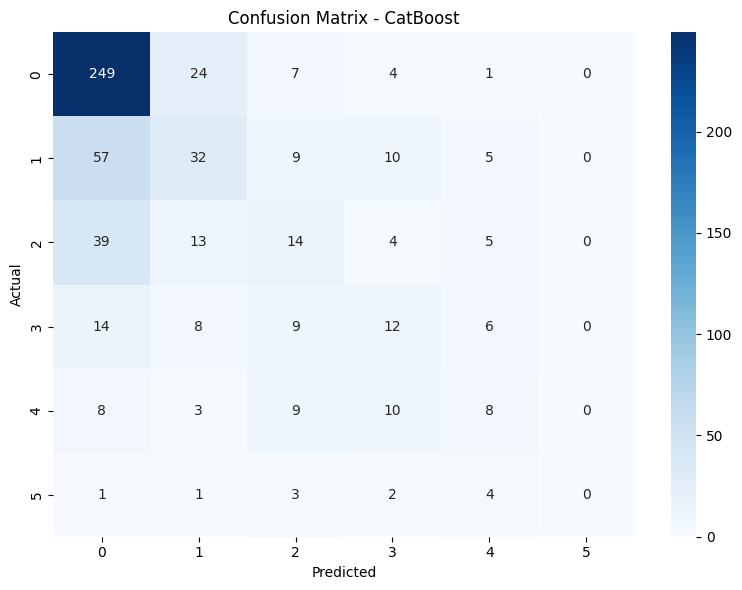

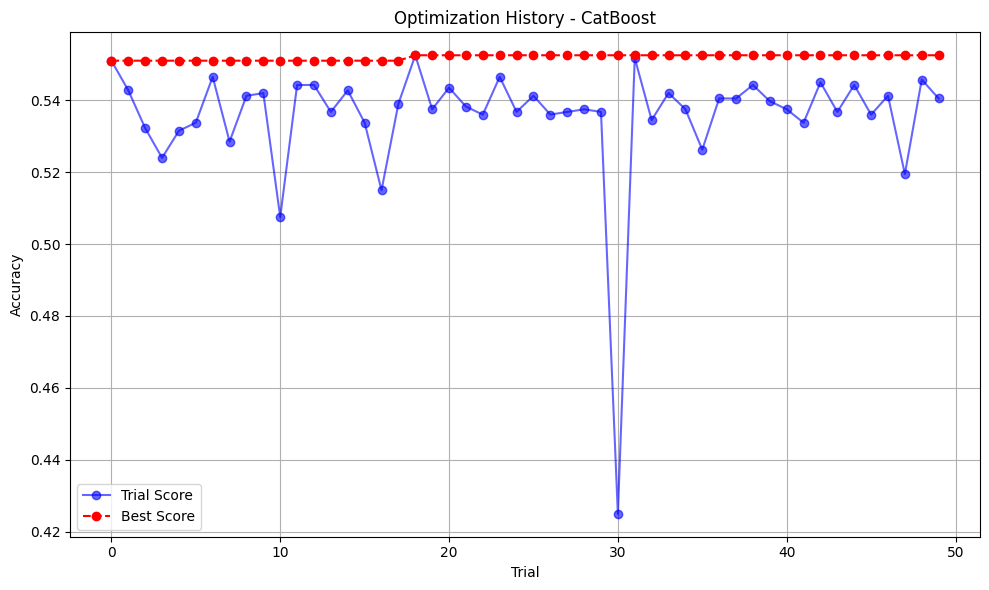

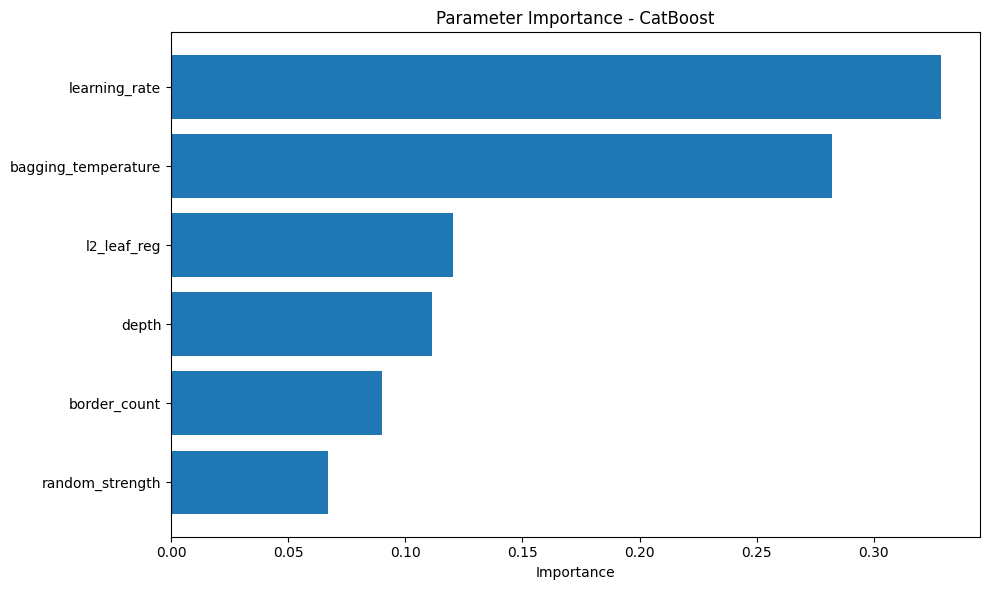


Tối ưu mô hình RandomForest với Optuna...


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'n_estimators': 399, 'max_depth': 43, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best CV Score: 0.5473
Test Accuracy: 0.5499 | Test F1: 0.5110
              precision    recall  f1-score   support

           0       0.66      0.87      0.75       285
           1       0.36      0.22      0.27       113
           2       0.28      0.20      0.23        75
           3       0.37      0.31      0.33        49
           4       0.30      0.21      0.25        38
           5       1.00      0.18      0.31        11

    accuracy                           0.55       571
   macro avg       0.49      0.33      0.36       571
weighted avg       0.51      0.55      0.51       571



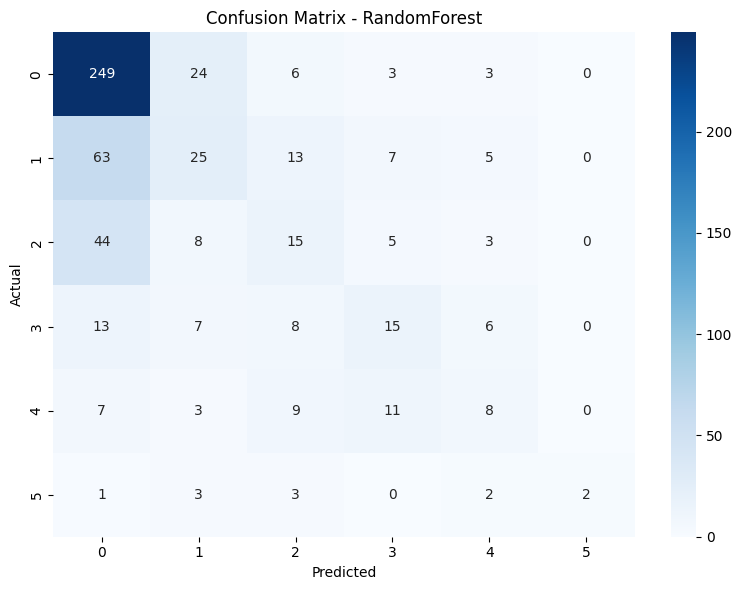

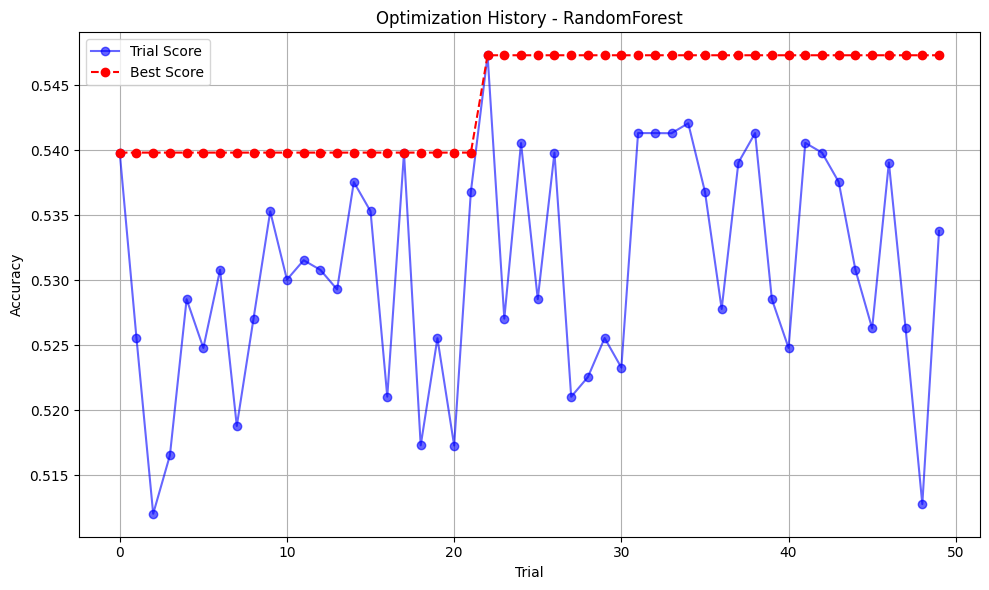

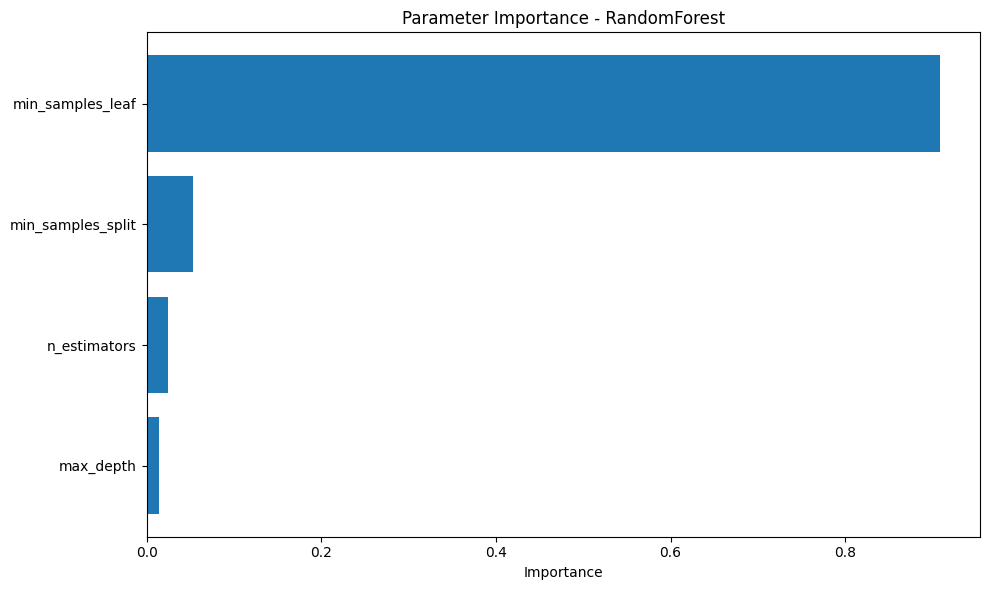


Tối ưu mô hình XGBoost với Optuna...


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'learning_rate': 0.002216372684335679, 'max_depth': 4, 'gamma': 0.3287567348601927, 'min_child_weight': 4, 'subsample': 0.6889407176466235, 'colsample_bytree': 0.6387078650061816, 'reg_alpha': 1.0481583735908725e-08, 'reg_lambda': 0.0005539497194800395}
Best CV Score: 0.5443
Test Accuracy: 0.5569 | Test F1: 0.5072
              precision    recall  f1-score   support

           0       0.66      0.90      0.76       285
           1       0.38      0.25      0.30       113
           2       0.24      0.13      0.17        75
           3       0.33      0.20      0.25        49
           4       0.37      0.34      0.36        38
           5       0.00      0.00      0.00        11

    accuracy                           0.56       571
   macro avg       0.33      0.30      0.31       571
weighted avg       0.49      0.56      0.51       571



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


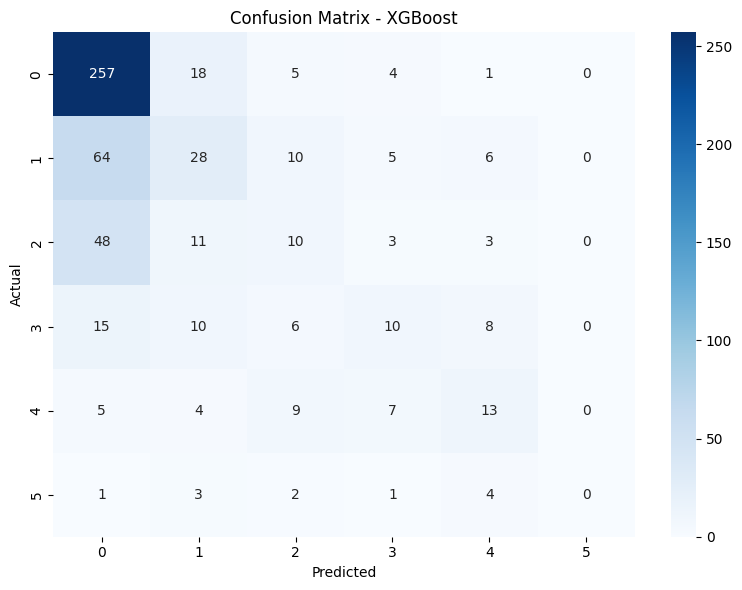

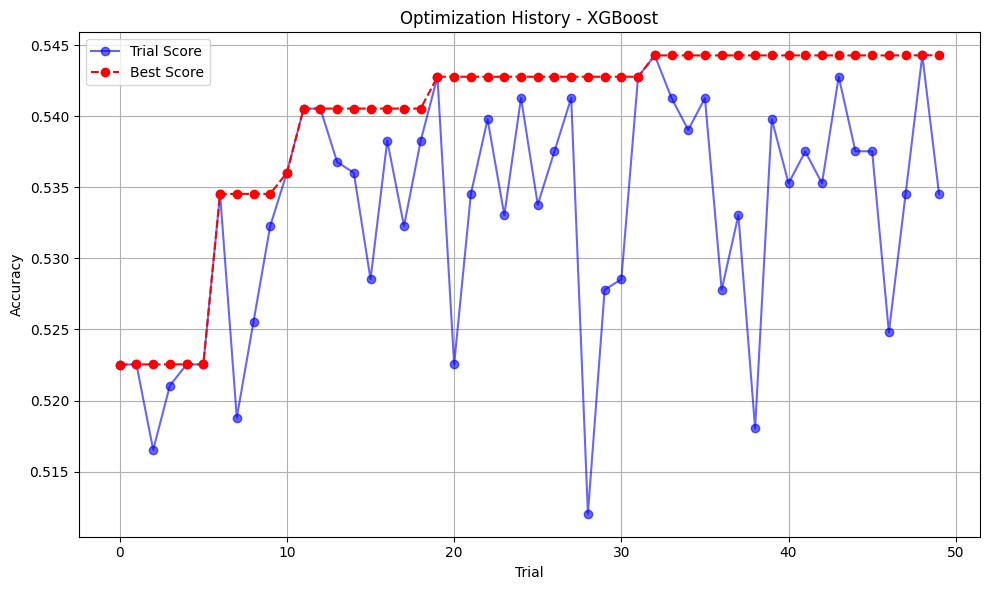

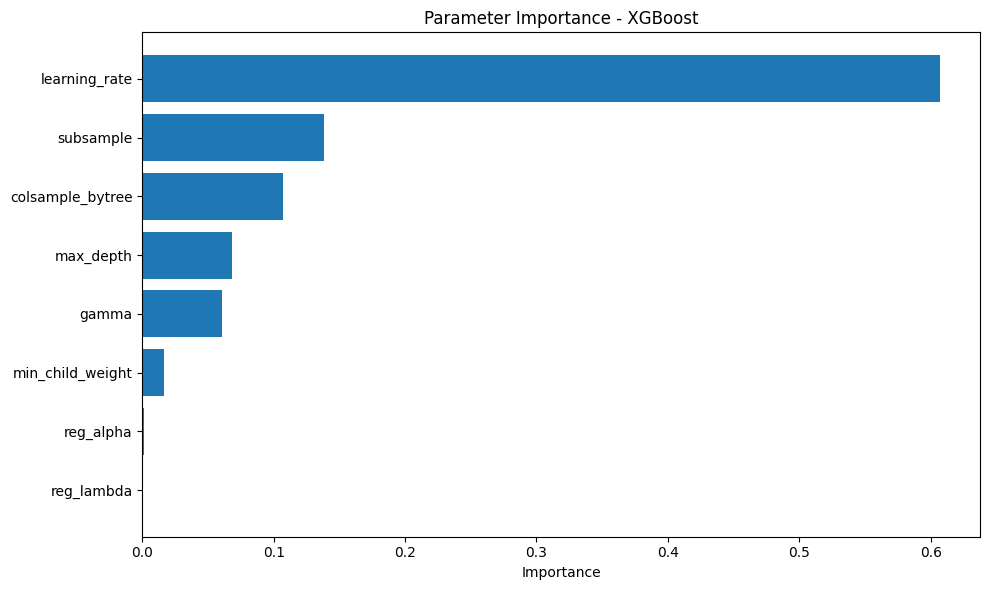


Mô hình đơn lẻ tốt nhất: CatBoost | CV Score: 0.5526

Phân tích feature importance cho mô hình tốt nhất...


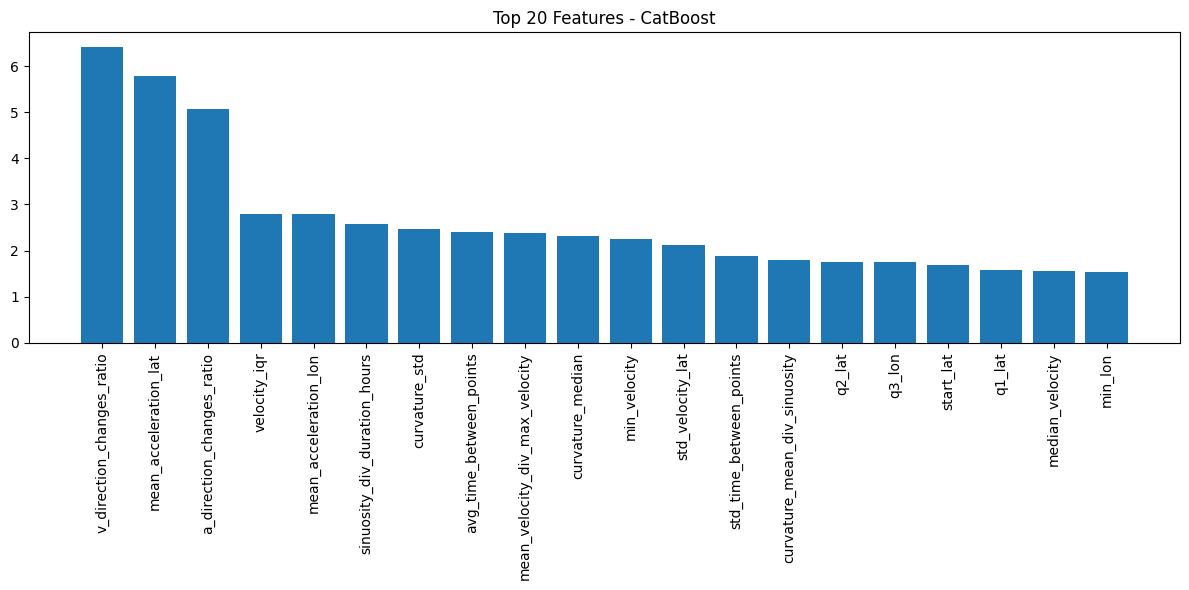

10 đặc trưng quan trọng nhất:
1. v_direction_changes_ratio: 6.4126
2. mean_acceleration_lat: 5.7829
3. a_direction_changes_ratio: 5.0673
4. velocity_iqr: 2.7865
5. mean_acceleration_lon: 2.7848
6. sinuosity_div_duration_hours: 2.5723
7. curvature_std: 2.4723
8. avg_time_between_points: 2.4059
9. mean_velocity_div_max_velocity: 2.3748
10. curvature_median: 2.3222

Top 3 mô hình cho ensemble: ['CatBoost', 'RandomForest', 'XGBoost']


In [5]:
# Cài đặt seed cho reproducibility
SEED = 0
np.random.seed(SEED)

# Kiểm tra GPU (nếu cần)
try:
    import torch
    has_cuda = torch.cuda.is_available()
    gpu_count = torch.cuda.device_count() if has_cuda else 0
    print(f"GPU support available: {has_cuda}")
    if has_cuda:
        print(f"Found {gpu_count} GPU(s): {', '.join([torch.cuda.get_device_name(i) for i in range(gpu_count)])}")
except Exception as e:
    has_cuda = False
    print("PyTorch không khả dụng, bỏ qua kiểm tra GPU:", e)

print("Trích xuất đặc trưng nâng cao...")
df = extract_enhanced_features(datasets)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

print("Xử lý outlier...")
df = handle_outliers(df, method='winsorize')

print("Tạo đặc trưng tương tác...")
df = create_interaction_features(df)

# Tách dữ liệu thành X và y, sau đó chia train/test với stratification
y = df['class']
X = df.drop(columns=['traj_id', 'class'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Pipeline tiền xử lý
preproc = Pipeline([('scaler', StandardScaler())])

# Định nghĩa các hàm tạo mô hình với tham số từ trial
model_factories = {
    'CatBoost': lambda trial: CatBoostClassifier(
        iterations= 200,
        learning_rate=trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        depth=trial.suggest_int('depth', 3, 12),
        l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        border_count=trial.suggest_int('border_count', 32, 255),
        bagging_temperature=trial.suggest_float('bagging_temperature', 0, 10.0),
        random_strength=trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        random_seed=SEED,
        logging_level='Silent',
        task_type='GPU',
        gpu_ram_part=0.2,
        devices='0',
        
    ),
    'RandomForest': lambda trial: RandomForestClassifier(
        n_estimators=trial.suggest_int('n_estimators', 100, 600),
        max_depth=trial.suggest_int('max_depth', 10, 50, log=True),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 5),
        class_weight='balanced',
        random_state=SEED,
        n_jobs=-1
    ),
    'XGBoost': lambda trial: XGBClassifier(
        n_estimators= 200,
        learning_rate=trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        max_depth=trial.suggest_int('max_depth', 3, 12),
        gamma=trial.suggest_float('gamma', 0, 0.5),
        min_child_weight=trial.suggest_int('min_child_weight', 1, 10),
        subsample=trial.suggest_float('subsample', 0.6, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.6, 1.0),
        reg_alpha=trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        reg_lambda=trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        random_state=SEED,
        use_label_encoder=False,
        eval_metric='mlogloss',
        n_jobs=-1,
        verbosity=0,
        tree_method='gpu_hist' if has_cuda else 'hist',
        gpu_id=0 if has_cuda else None
    )
}

# Tối ưu từng mô hình với Optuna
best_models = {}
best_scores = {}

for model_name, model_factory in model_factories.items():
    print(f"\nTối ưu mô hình {model_name} với Optuna...")
    
    def objective(trial):
        clf = model_factory(trial)
        pipe = Pipeline([
            ('preproc', preproc),
            ('clf', clf)
        ])
        cv_scores = cross_val_score(
            pipe, X_train, y_train,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
            scoring='accuracy',
            n_jobs=-1
        )
        return np.mean(cv_scores)
    
    # Tạo study và thiết lập một số thông số
    study = optuna.create_study(direction='maximize')
    n_trials = 50
    
    # Sử dụng optuna.logging để ẩn các log không cần thiết
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    # Sử dụng built-in progress bar của Optuna thay vì tqdm
    study.optimize(objective, n_trials=n_trials, n_jobs=1, show_progress_bar=True)
    
    best_params = study.best_params
    best_score = study.best_value
    print(f"Best parameters: {best_params}")
    print(f"Best CV Score: {best_score:.4f}")
    
    best_clf = model_factory(optuna.trial.FixedTrial(best_params))
    best_pipe = Pipeline([
        ('preproc', preproc),
        ('clf', best_clf)
    ])
    best_pipe.fit(X_train, y_train)
    best_models[model_name] = best_pipe
    best_scores[model_name] = best_score
    
    # Đánh giá trên tập test
    y_pred = best_pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Test Accuracy: {acc:.4f} | Test F1: {f1:.4f}")
    print(classification_report(y_test, y_pred))
    
    # --- Visualization cho mô hình riêng ---
    # 1. Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=sorted(y.unique()),
                yticklabels=sorted(y.unique()))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    # 2. Vẽ lịch sử tối ưu hóa (Optimization History)
    trials = [t.value for t in study.trials if t.value is not None]
    best_values = np.maximum.accumulate(trials)
    plt.figure(figsize=(10, 6))
    plt.plot(trials, marker='o', linestyle='-', color='blue', alpha=0.6, label='Trial Score')
    plt.plot(best_values, marker='o', linestyle='--', color='red', label='Best Score')
    plt.xlabel('Trial')
    plt.ylabel('Accuracy')
    plt.title(f'Optimization History - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # 3. Vẽ tầm quan trọng các tham số (Parameter Importance)
    try:
        param_importance = optuna.importance.get_param_importances(study)
        if param_importance:
            # Sắp xếp theo giá trị giảm dần
            sorted_params = sorted(param_importance.items(), key=lambda x: x[1], reverse=True)
            params, importances = zip(*sorted_params)
            plt.figure(figsize=(10, 6))
            plt.barh(params, importances)
            plt.xlabel('Importance')
            plt.title(f'Parameter Importance - {model_name}')
            plt.gca().invert_yaxis()  # Tham số quan trọng nhất ở đầu
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print("Không thể hiển thị tầm quan trọng của tham số:", e)

# Chọn mô hình có hiệu năng tốt nhất dựa trên CV score
best_model_name = max(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]
print(f"\nMô hình đơn lẻ tốt nhất: {best_model_name} | CV Score: {best_scores[best_model_name]:.4f}")

# Phân tích và trực quan hoá feature importance
print("\nPhân tích feature importance cho mô hình tốt nhất...")
try:
    feature_names = X.columns
    importances = best_model.named_steps['clf'].feature_importances_
    indices = np.argsort(importances)[::-1][:20]
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(indices)), importances[indices])
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.title(f'Top 20 Features - {best_model_name}')
    plt.tight_layout()
    plt.show()
    
    print("10 đặc trưng quan trọng nhất:")
    for i in range(min(10, len(indices))):
        print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")
except Exception as e:
    print("Không thể trích xuất feature importance:", e)

# --- Xây dựng ensemble voting từ các mô hình đã tối ưu ---
top_models = sorted(best_scores.items(), key=lambda x: x[1], reverse=True)[:3]
top_model_names = [name for name, _ in top_models]
print(f"\nTop 3 mô hình cho ensemble: {top_model_names}")

## <h1 style="font-family: 'Poppins', sans-serif; font-size: 30px; font-weight: bold; color: #ffffff; text-align: center; padding: 10px 10px; background-color: #2196F3; border-radius: 60px; box-shadow: 0 10px 20px rgba(0, 0, 0, 0.2), 0 4px 6px rgba(0, 0, 0, 0.1); letter-spacing: 1px; border: 1px solid #2196F3;"> VOTING ENSEMBLE METHODS</h1>



Hard Voting Ensemble - Test Accuracy: 0.5464 | Test F1: 0.5061
              precision    recall  f1-score   support

           0       0.67      0.88      0.76       285
           1       0.41      0.27      0.32       113
           2       0.25      0.17      0.20        75
           3       0.25      0.20      0.22        49
           4       0.29      0.24      0.26        38
           5       0.00      0.00      0.00        11

    accuracy                           0.55       571
   macro avg       0.31      0.29      0.29       571
weighted avg       0.49      0.55      0.51       571



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


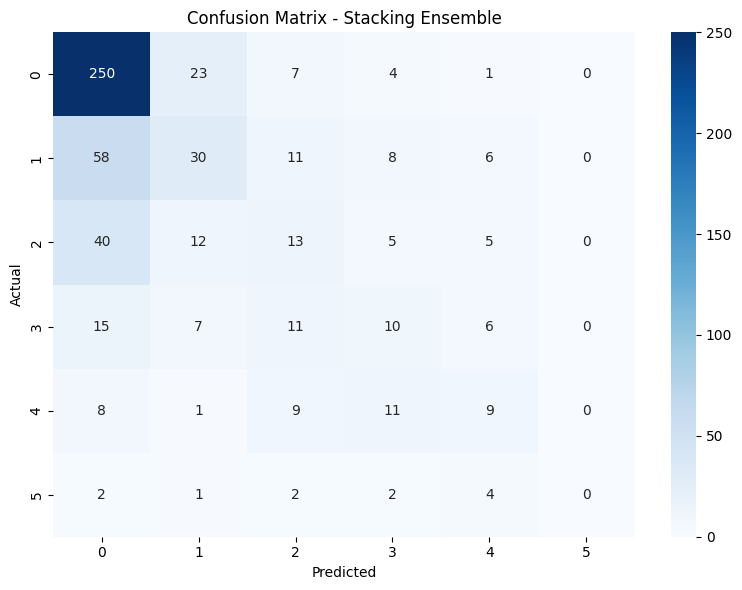


Tổng hợp kết quả các mô hình:
             Model  Accuracy  F1 Score
0         CatBoost  0.551664  0.513649
1  Voting Ensemble  0.546410  0.506096


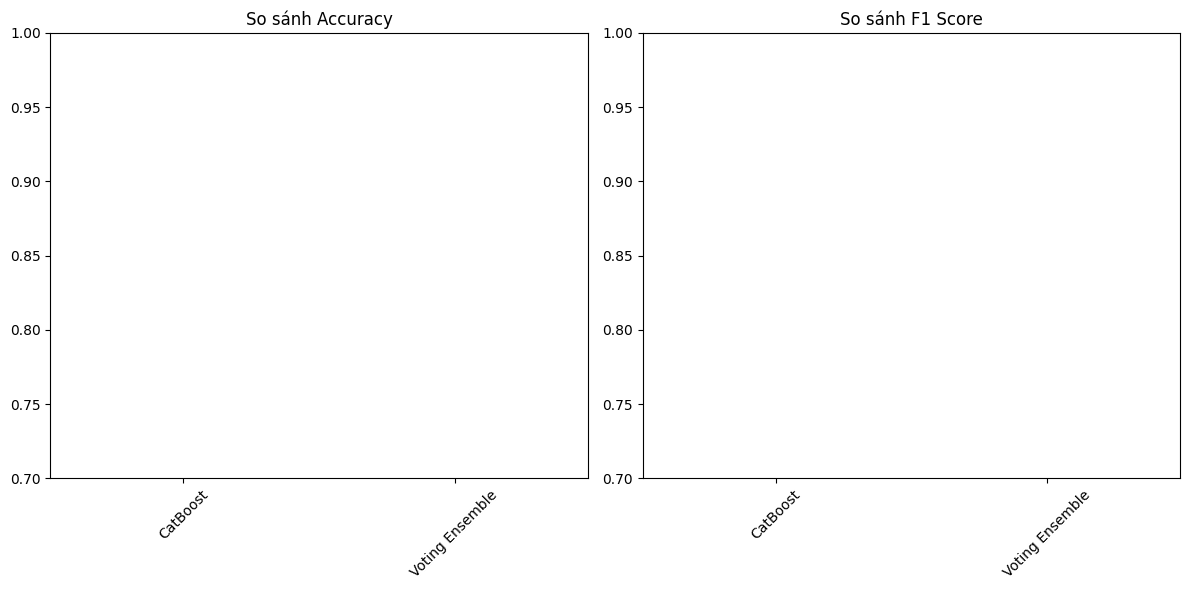


Mô hình cuối cùng tốt nhất: CatBoost
Accuracy: 0.5517 | F1 Score: 0.5136


In [7]:
# Chuẩn bị estimators cho VotingClassifier
estimators = [(name, best_models[name]) for name in top_model_names]

# Hard voting (phương thức bỏ phiếu cứng - lấy đa số)
voting_soft = VotingClassifier(
    estimators=estimators,
    voting='soft',
    n_jobs=-1
)
voting_soft.fit(X_train, y_train)

# Đánh giá voting ensembles
y_pred_hard = voting_soft.predict(X_test)
acc_hard = accuracy_score(y_test, y_pred_hard)
f1_hard = f1_score(y_test, y_pred_hard, average='weighted')
print(f"\nHard Voting Ensemble - Test Accuracy: {acc_hard:.4f} | Test F1: {f1_hard:.4f}")
print(classification_report(y_test, y_pred_hard))

plt.figure(figsize=(8, 6))
cm_voting = confusion_matrix(y_test, y_pred_hard)
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.title('Confusion Matrix - Stacking Ensemble')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# --- So sánh kết quả các mô hình ---
results = {
    best_model_name: {
        'accuracy': accuracy_score(y_test, best_model.predict(X_test)),
        'f1': f1_score(y_test, best_model.predict(X_test), average='weighted'),
        'model': best_model
    },
    'Voting Ensemble': {
        'accuracy': acc_hard,
        'f1': f1_hard,
        'model': voting_hard
    }
}

result_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[k]['accuracy'] for k in results],
    'F1 Score': [results[k]['f1'] for k in results]
})

print("\nTổng hợp kết quả các mô hình:")
print(result_df.sort_values('F1 Score', ascending=False))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(result_df['Model'], result_df['Accuracy'], color='b')
plt.title('So sánh Accuracy')
plt.ylim(0.7, 1.0)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(result_df['Model'], result_df['F1 Score'], color='g')
plt.title('So sánh F1 Score')
plt.ylim(0.7, 1.0)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

best_final_model_name = max(results, key=lambda k: results[k]['f1'])
best_final_model = results[best_final_model_name]['model']
print(f"\nMô hình cuối cùng tốt nhất: {best_final_model_name}")
print(f"Accuracy: {results[best_final_model_name]['accuracy']:.4f} | F1 Score: {results[best_final_model_name]['f1']:.4f}")

---
---
---
---
---
---

**Nhận xét:**
- 1. `mean_lon` & `mean_lat`: Có dạng phân phối gần với chuẩn (Gaussian), đặc biệt là `mean_lat`. Điều này phản ánh rằng các cơn bão thường xuất hiện quanh một dải vĩ độ – kinh độ phổ biến (khả năng gần khu vực nhiệt đới).
     
- 2. `path_length`, `traj_duration`, `v_changes`, `a_changes`: Có dạng phân phối lệch phải rõ rệt, có đuôi dài. Hầu hết các cơn bão có quãng đường, thời gian tồn tại, số lần thay đổi vận tốc/gia tốc nhỏ, chỉ một số ít có giá trị rất cao → có thể là outlier hoặc bão mạnh/hiếm gặp.

- 3. `velocity` & `acceleration`: Các đặc trưng như mean, std, max, đều có phân phối lệch phải. Điều này cho thấy đa số các cơn bão có vận tốc và gia tốc thấp, chỉ một phần nhỏ có tốc độ rất cao.

- 4. `lon_range` & `lat_range`: Có dạng phân phối lệch phải, hầu hết các cơn bão chỉ di chuyển trong một khoảng không gian nhỏ, nhưng cũng có một số trường hợp di chuyển rất rộng.

- 5. `curvature_mean`: đa số cơn bão có đường đi khá thẳng, chỉ một vài có quỹ đạo cong ngoằn ngoèo.

**Nhận xét:** Có rất nhiều đặc trưng có outlier nằm ngoài IQR (hộp boxplot). Ngoài trừ cột `mean_lon` & `mean_lat`, các cột khác có đuôi phải rất dài → Đây là ứng viên cho log-transform hoặc xử lý outlier.

**Nhận xét:** Nhiều thuộc tính của đường đi bão (như `path_length`, `traj_duration`, `max_velocity`, `max_acceleration` và phạm vi địa lý (`lon_range`, `lat_range`, `curvature_mean` )) có mối liên hệ tương quan dương với bão cấp độ. Điều này có nghĩa là các cơn bão mạnh hơn thường có xu hướng di chuyển dài hơn, tồn tại lâu hơn, đạt vận tốc và gia tốc cao hơn, và bao phủ một khu vực rộng hơn. Tuy nhiên, một số thuộc tính khác (như `mean_velocity` và `mean_acceleration`) không thể hiện xu hướng rõ ràng theo cấp độ bão.

**Nhận xét:** 
- Path Length vs Trajectory Duration: Có mối liên hệ tương quan mạnh mẽ. Các cơn bão di chuyển quãng đường dài hơn thường kéo dài lâu hơn. 
- Mean Longitude vs Mean Latitude: Các điểm có vẻ tập trung trong một khu vực nhất định.
- Longitude Range vs Latitude Range: Có vẻ như có một mối tương quan. Các cơn bão lan theo chiều ngang cũng có xu hướng lan rộng theo chiều dọc.
- Mean Velocity vs Mean Acceleration: Không có mối quan hệ rõ ràng.
- Std Velocity vs Std Acceleration: Có vẻ như có một mối tương quan dương nhẹ. Các cơn bão có biến động lớn hơn về tốc độ cũng có xu hướng có biến động lớn hơn về tốc độ.
- Max Velocity vs Max Acceleration: Có một mối tương quan rõ ràng. Các cơn bão đạt tốc độ cao nhất cũng có xu hướng có gia tốc lớn nhất.

**Nhận xét:**
- Path Length vs Max Velocity: Có một xu hướng tăng nhẹ, các cơn bão có chiều dài đường đi lớn hơn có xu hướng đạt vận tốc tối đa cao hơn. Tuy nhiên, có sự phân tán đáng kể, cho thấy chiều dài đường đi không phải là yếu tố duy nhất quyết định vận tốc tối đa.
Các cơn bão cấp độ 0 có xu hướng tập trung ở vùng chiều dài đường đi ngắn và vận tốc tối đa thấp.

- Trajectory Duration vs Max Velocity: có một xu hướng tăng nhẹ: các cơn bão có thời gian di chuyển dài hơn có xu hướng đạt vận tốc tối đa cao hơn. Sự phân tán cũng tương đối lớn. Các cơn bão cấp độ 0 tập trung ở vùng thời gian di chuyển ngắn và vận tốc tối đa thấp.

- Max Velocity vs Std Velocity: Có một mối tương quan dương mạnh mẽ: các cơn bão có vận tốc tối đa cao hơn cũng có độ lệch chuẩn vận tốc (sự biến động của vận tốc)lớn hơn. Các điểm dữ liệu có xu hướng tạo thành một dải hẹp, cho thấy mối quan hệ tuyến tính tương đối rõ ràng.
Các cấp độ bão cao hơn tập trung ở vùng vận tốc tối đa và độ lệch chuẩn vận tốc cao hơn.

- Max Acceleration vs Std Acceleration: Có một mối tương quan dương mạnh mẽ: các cơn bão có gia tốc tối đa cao hơn cũng có độ lệch chuẩn gia tốc (sự biến động của gia tốc) lớn hơn. Mối quan hệ này có vẻ chặt chẽ hơn so với vận tốc.
Các cấp độ bão cao hơn tập trung ở vùng gia tốc tối đa và độ lệch chuẩn gia tốc cao hơn.

- Lon Range vs Mean Lon, Lon Range vs Mean Lat, Lat Range vs Mean Lon, Lat Range vs Mean Lat: Không có mối tương quan rõ ràng. Các điểm dữ liệu phân tán rộng rãi. không có sự tách biệt mạnh mẽ theo cấp độ bão.